# Evaluating and comparing the trained models

This notebook evaluates the trained models and compares them to each other. The evaluation is done on the test dataset.

In [1]:
# Select device to run the evaluation on
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import time

from datetime import datetime
from src.utils.utils_json import *

models = [
    "clever_villani",     # Sketch model, 3000 iterations
    "practical_wilson",   # Standard model, 3000 iterations, with keypoints
    "great_swirles",      # Standard model, 3000 iterations, without keypoints
    "amazing_ramanujan",  # Sketch model, 30000 iterations
]

reports = {}

for model in models:
    filename = os.path.join("reports", f"{model}.json")
    data = read_json(filename)

    if "model_name" not in data:
        data["model_name"] = model

    reports[model] = data

In [3]:
import re

input_data = {
    "model": [],
    "date": [],
    "iterations": [],
    "batch_size": [],
    "training_time": [],
    "bbox_AP": [],
    "keypoint_on": [],
    "metrics_file": [],
    "dataset": [],
    "ROI_HEADS_NAME": [],
    "model_zoo": [],
}

for inx, data in reports.items():
    config = read_json(data["config_file"])
    iterations = config["SOLVER"]["MAX_ITER"]
    batch_size = config["SOLVER"]["IMS_PER_BATCH"]
    keypoint_on = config["MODEL"]["KEYPOINT_ON"]

    # cfg.MODEL.ROI_HEADS.NAME
    input_data["ROI_HEADS_NAME"].append(config["MODEL"]["ROI_HEADS"]["NAME"])

    # Pretrained model name
    # https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl
    weights_url = config["MODEL"]["WEIGHTS"]
    pattern = r'/(faster_rcnn_.*?)/'
    result = re.search(pattern, weights_url)

    if result:
        extracted_text = result.group(1)
        input_data["model_zoo"].append(extracted_text)
    else:
        input_data["model_zoo"].append("")

    # Check if config field date exists
    if "date" in data:
        date = data["date"]
    else:
        date = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

    input_data["model"].append(data["model_name"])
    input_data["date"].append(date)
    input_data["iterations"].append(iterations)
    input_data["batch_size"].append(batch_size)
    input_data["training_time"].append(data["training_time"])
    input_data["bbox_AP"].append(data["inference"]["bbox"]["AP"])
    input_data["keypoint_on"].append(keypoint_on)
    input_data["metrics_file"].append(data["metrics_file"])
    input_data["dataset"].append(data["training_data"])

In [4]:
import pandas as pd

df = pd.DataFrame(input_data)

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

### Collect metrics from metrics.json
```json
{
  "data_time": 0.001142542518209666,
  "eta_seconds": 119.06942527508363,
  "fast_rcnn/cls_accuracy": 0.8489583333333334,
  "fast_rcnn/false_negative": 0.40104166666666663,
  "fast_rcnn/fg_cls_accuracy": 0.5416666666666666,
  "iteration": 659,
  "keypoint_head/num_fg_samples": 6.333333333333333,
  "loss_box_reg": 0.5005353689193726,
  "loss_cls": 0.4705694764852524,
  "loss_keypoint": 4.670206069946289,
  "loss_rpn_cls": 0.04379798099398613,
  "loss_rpn_loc": 0.1723681092262268,
  "lr": 0.0032967050000000005,
  "roi_head/num_bg_samples": 96,
  "roi_head/num_fg_samples": 32,
  "rpn/num_neg_anchors": 128,
  "rpn/num_pos_anchors": 128,
  "time": 0.3637188300199341,
  "total_loss": 5.902021748945117
}
```

In [5]:
total_loss = []
loss_box_reg = []
loss_cls = []
loss_arrow_reg = []

for inx, row in df.iterrows():
    filename = row["metrics_file"]

    # Read last line of metrics file
    with open(filename, 'r') as file:
        last_line = file.readlines()[-1]

    # Convert string to json
    metrics_conclusion = json.loads(last_line)

    #print_json(metrics_conclusion, tag=row['model'])

    total_loss.append(metrics_conclusion['total_loss'])
    loss_box_reg.append(metrics_conclusion['loss_box_reg'])
    loss_cls.append(metrics_conclusion['loss_cls'])

    if "loss_arrow_reg" in metrics_conclusion:
        loss_arrow_reg.append(metrics_conclusion['loss_arrow_reg'])
    else:
        loss_arrow_reg.append(None)


In [6]:
df['total_loss'] = total_loss
df['loss_box_reg'] = loss_box_reg
df['loss_cls'] = loss_cls
df['loss_arrow_reg'] = loss_arrow_reg

# Remove metrics_file column
df = df.drop(columns=['metrics_file'])

df

,model,date,iterations,batch_size,training_time,bbox_AP,keypoint_on,dataset,ROI_HEADS_NAME,model_zoo,total_loss,loss_box_reg,loss_cls,loss_arrow_reg
0,clever_villani,2023-09-09 23:14:11,3000,10,7628.445127,58.502434,True,datasets/hdBPMN-icdar2021,SketchROIHeads,faster_rcnn_X_101_32x8d_FPN_3x,0.427732,0.166213,0.088031,0.094653
1,practical_wilson,2023-09-10 13:36:55,3000,10,8423.267806,54.325692,True,datasets/hdBPMN-icdar2021,StandardROIHeads,faster_rcnn_X_101_32x8d_FPN_3x,3.434319,0.241523,0.153126,NaN
2,great_swirles,2023-09-13 18:27:36,3000,10,7605.119175,59.263377,False,datasets/hdBPMN-icdar2021,StandardROIHeads,faster_rcnn_X_101_32x8d_FPN_3x,0.312290,0.160206,0.081878,NaN
3,amazing_ramanujan,2023-09-11 15:49:36,30000,10,79013.246994,60.110533,True,datasets/hdBPMN-icdar2021,SketchROIHeads,faster_rcnn_X_101_32x8d_FPN_3x,0.157467,0.063495,0.030773,0.033223


### Evaluation of the trained models

In [7]:
# This needs to be imported because the model uses a custom classes that need to be registered
from src.sketch_detection_rcnn.roi_heads import SketchROIHeads  # noqa # pylint: disable=unused-import

In [8]:
model_name = 'amazing_ramanujan'

model_meta = reports[model_name]

In [9]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_meta["config_file"])

# path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join("models", model_name, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [10]:
def count_classes(classes: list[int]) -> dict[int, int]:
    class_count = {}
    for key in classes:
        if key in class_count:
            class_count[key] += 1
        else:
            class_count[key] = 1

    return class_count

In [11]:
from src.dataset.dataset import read_dateset_from

validation_dataset = read_dateset_from(model_meta["training_data"], "test")

In [12]:
import cv2
import torch

from typing import Tuple
from detectron2.utils.visualizer import Visualizer
from src.visualization.visualize import show_img
from src.utils.utils_bbox import bbox_iou


def annotations_to_bboxes(annotations) -> torch.Tensor:
    boxes = []

    for annotation in annotations:
        bbox = annotation["bbox"]
        boxes.append([
            bbox[0],  # x
            bbox[1],  # y
            bbox[0] + bbox[2],  # x + width
            bbox[1] + bbox[3],  # y + height
        ])

    return torch.tensor(boxes, device=device)


def match_bounding_boxes(gt, pred, threshold: float = 0.5) -> list[Tuple[int, int, float]]:
    matches = []

    gt_box = annotations_to_bboxes(gt["annotations"])
    pred_box = pred["instances"].pred_boxes.tensor

    for inx in range(len(gt_box)):
        best_iou = 0
        best = None

        for iny in range(len(pred_box)):
            iou = bbox_iou(gt_box[inx], pred_box[iny])

            if iou > best_iou:
                best_iou = iou
                best = (inx, iny, iou)

        if best_iou >= threshold:
            matches.append(best)

    return matches


def box_tp_fn_fp(matches, gt, pred) -> Tuple[int, int, int]:
    tp = len(matches)
    fn = len(gt["annotations"]) - tp
    fp = len(pred["instances"]) - tp

    return tp, fn, fp

In [13]:
def class_tp_fn_fp(ground_truth, predictions) -> Tuple[int, int, int]:
    # Count ground truth classes
    gt_classes = [anno["category_id"] for anno in ground_truth["annotations"]]
    gt_class_count = count_classes(gt_classes)

    # Count predicted classes
    pred_classes = predictions["instances"].pred_classes.tolist()
    pred_class_count = count_classes(pred_classes)

    # Combine gt and pred class keys
    classes_all = list(set(gt_classes + pred_classes))

    # Calculate tp, fn, fp for each class
    tp, fn, fp = 0, 0, 0

    for class_key in classes_all:
        gt_count = gt_class_count[class_key] if class_key in gt_class_count else 0
        pred_count = pred_class_count[class_key] if class_key in pred_class_count else 0

        tp += min(gt_count, pred_count)
        fn += max(0, gt_count - pred_count)
        fp += max(0, pred_count - gt_count)

    return tp, fn, fp


def class_tp_fn(matches: list, ground_truth, predictions) -> Tuple[int, int]:
    # Calculate tp, fn, fp for each class
    tp, fn = 0, 0

    for match in matches:
        gt_inx = match[0]
        pred_inx = match[1]

        gt_class = ground_truth["annotations"][gt_inx]["category_id"]
        pred_class = predictions["instances"].pred_classes[pred_inx]

        if gt_class == pred_class:
            tp += 1
        else:
            fn += 1

    return tp, fn

In [14]:
def precision_recall_f1(tp: float, fn: float, fp: float) -> Tuple[float, float, float]:
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1


def sensitivity(tp: float, fn: float) -> float:
    return tp / (tp + fn)

In [15]:
example_gt = validation_dataset[3]

# Set threshold for bounding box matching (IoU)
bbox_threshold = 0.75

im = cv2.imread(example_gt["file_name"])
example_prediction = predictor(im)

/home/jupyter-patrickzierahn/.local/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
example_matches = match_bounding_boxes(example_gt, example_prediction, bbox_threshold)

box_tp, box_fn, box_fp = box_tp_fn_fp(example_matches, example_gt, example_prediction)
print(f"Bounding Boxes:")
print(f"- True-Positives:  {box_tp}")
print(f"- False-Negatives: {box_fn}")
print(f"- False-Positives: {box_fp}")

box_precision, box_recall, box_f1 = precision_recall_f1(box_tp, box_fn, box_fp)
print(f"- Precision:       {box_precision}")
print(f"- Recall:          {box_recall}")
print(f"- F1:              {box_f1}")

Bounding Boxes:
- True-Positives:  11
- False-Negatives: 12
- False-Positives: 11
- Precision:       0.5
- Recall:          0.4782608695652174
- F1:              0.4888888888888889


In [17]:
class_tp, class_fn = class_tp_fn(example_matches, example_gt, example_prediction)
print(f"Classifications:")
print(f"- True-Positives:  {class_tp}")
print(f"- False-Negatives: {class_fn}")

class_sensitivity = sensitivity(class_tp, class_fn)
print(f"- Sensitivity:     {class_sensitivity}")

Classifications:
- True-Positives:  11
- False-Negatives: 0
- Sensitivity:     1.0


Ground truth


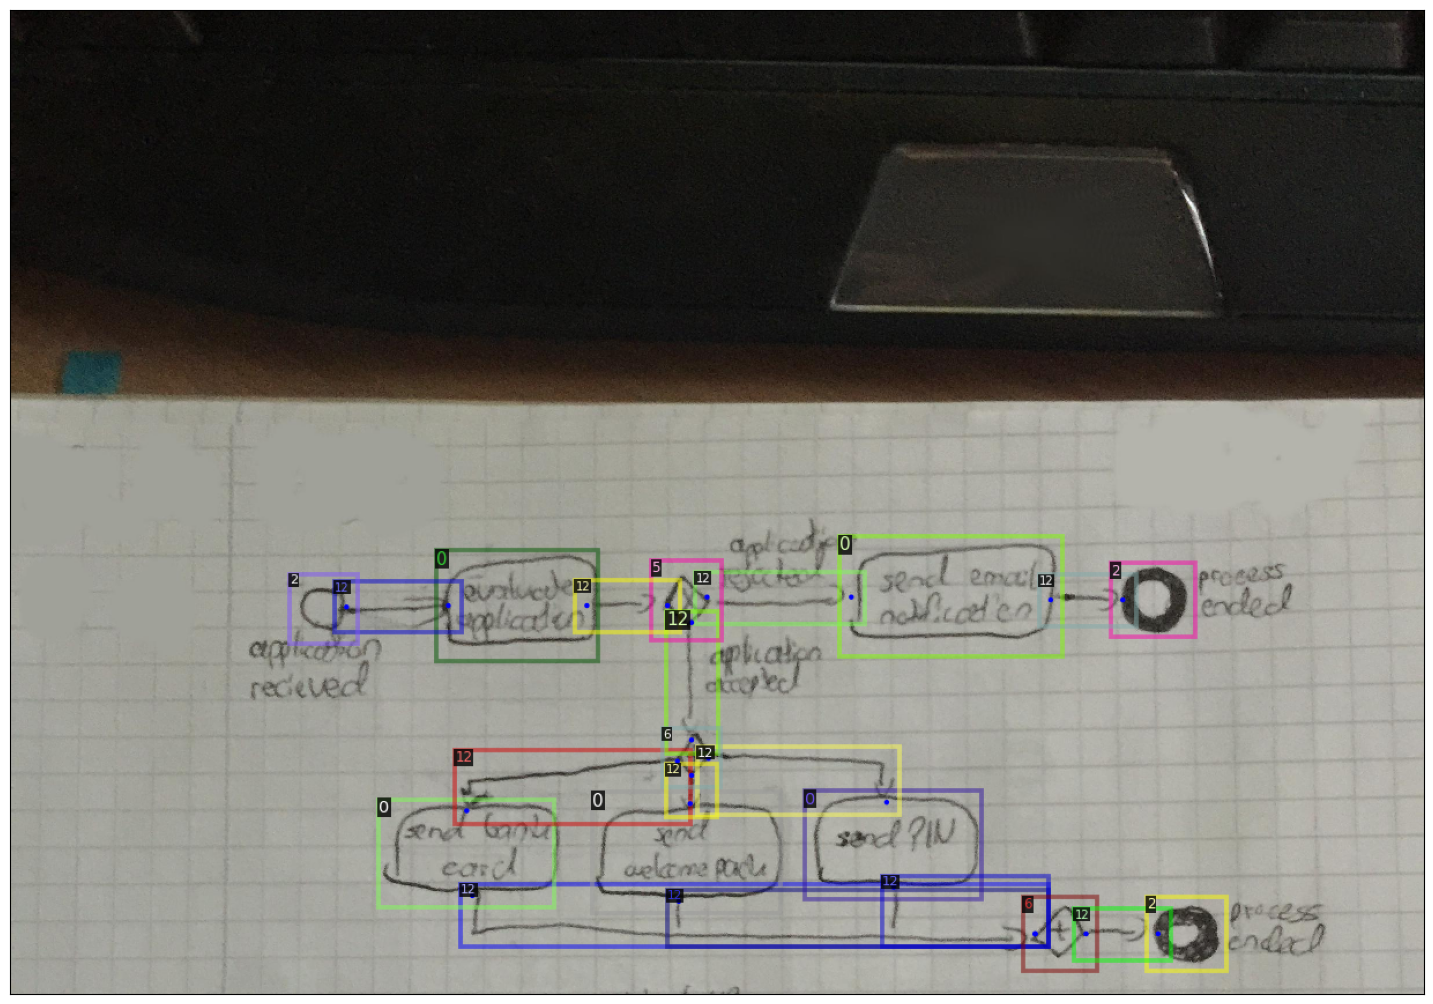

Predictions


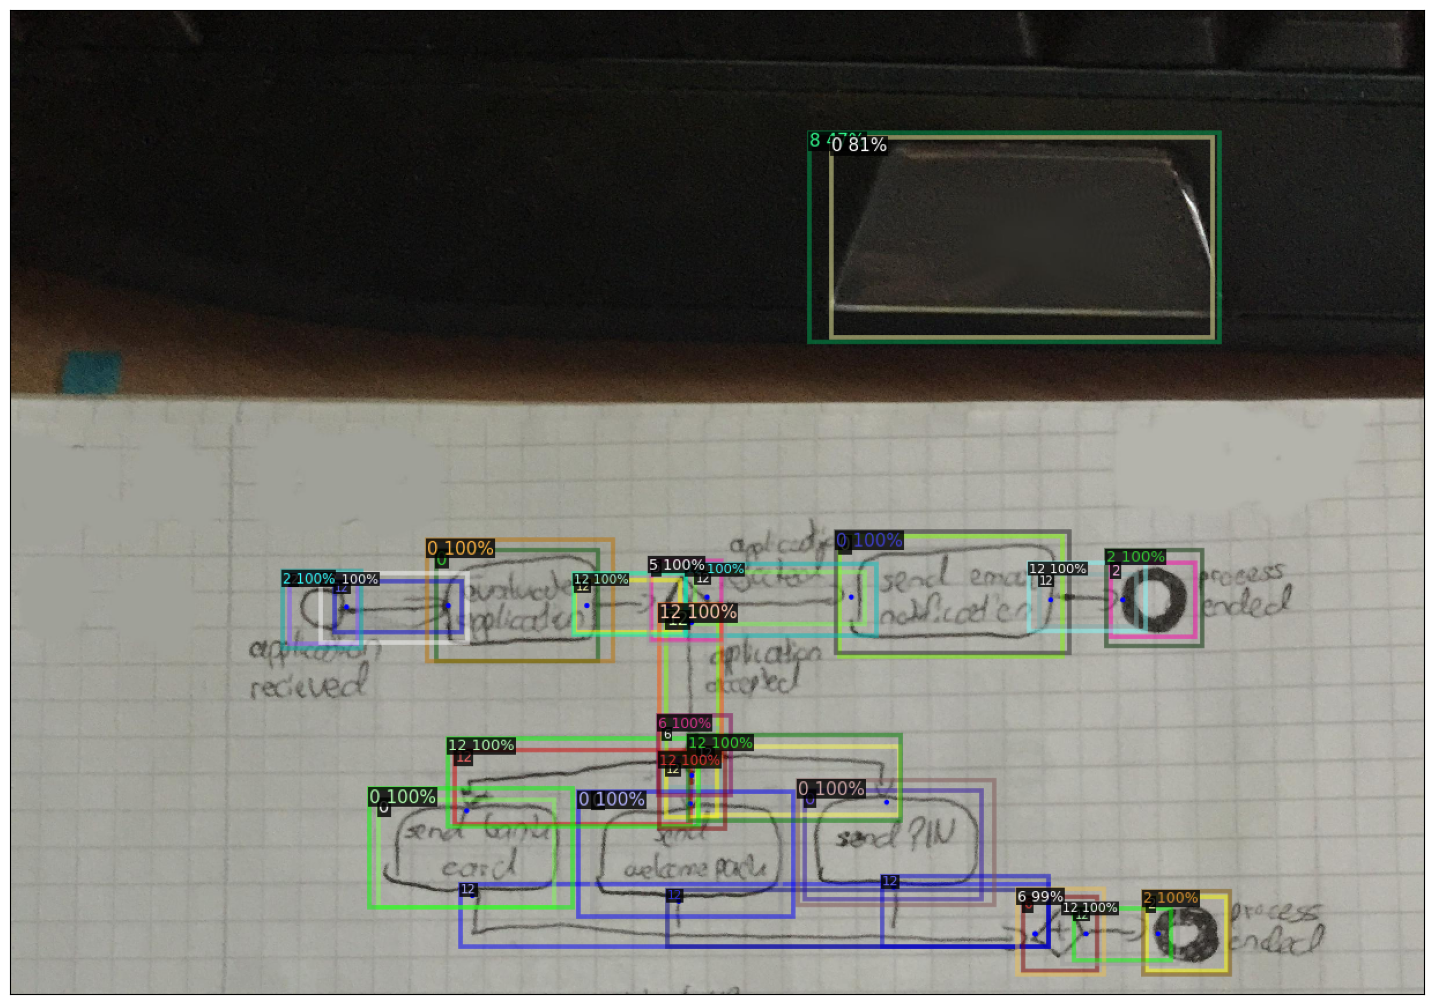

In [18]:
# remove the colors of unsegmented pixels. This option is only available for segmentation models
visualizer = Visualizer(im, scale=0.5)

print("Ground truth")
gt_out = visualizer.draw_dataset_dict(example_gt)
show_img(gt_out.get_image())

print("Predictions")
pred_out = visualizer.draw_instance_predictions(example_prediction["instances"].to("cpu"))
show_img(pred_out.get_image())

In [19]:
# Collect garbage...
del predictor

### Calculate statistics for all models

In [20]:
import tqdm

box_precisions, box_recalls, box_f1s = [], [], []
class_sensitivities = []
validation_count = []

for index, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    model_name = row["model"]
    model_meta = reports[model_name]

    cfg = get_cfg()
    cfg.merge_from_file(model_meta["config_file"])

    # path to the model we just trained
    cfg.MODEL.WEIGHTS = os.path.join("models", model_name, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set a custom testing threshold

    predictor = DefaultPredictor(cfg)

    box_tp, box_fn, box_fp = 0, 0, 0
    class_tp, class_fn = 0, 0

    validation_dataset = read_dateset_from(model_meta["training_data"], "val")
    validation_count.append(len(validation_dataset))

    for datapoint in validation_dataset:
        filename = datapoint["file_name"]
        im = cv2.imread(filename)
        predictions = predictor(im)

        matches = match_bounding_boxes(datapoint, predictions, bbox_threshold)

        # Calculate box tp, fn and fp
        box_tp_, box_fn_, box_fp_ = box_tp_fn_fp(matches, datapoint, predictions)
        box_tp += box_tp_
        box_fn += box_fn_
        box_fp += box_fp_

        # Calculate class tp and fn
        class_tp_, class_fn_ = class_tp_fn(matches, datapoint, predictions)
        class_tp += class_tp_
        class_fn += class_fn_

    # Calculate box precision, recall and f1
    box_precision, box_recall, box_f1 = precision_recall_f1(box_tp, box_fn, box_fp)

    box_precisions.append(box_precision)
    box_recalls.append(box_recall)
    box_f1s.append(box_f1)

    # Calculate class sensitivity
    class_sensitivity = sensitivity(class_tp, class_fn)
    class_sensitivities.append(class_sensitivity)

    del predictor

df["validation_count"] = validation_count
df["box_precision"] = box_precisions
df["box_recall"] = box_recalls
df["box_f1"] = box_f1s

df["class_sensitivity"] = class_sensitivities

100%|██████████| 4/4 [04:52<00:00, 73.16s/it]


In [21]:
df.to_csv(os.path.join("reports", "sketch_evaluation.csv"), index=False)
df

,model,date,iterations,batch_size,training_time,bbox_AP,keypoint_on,dataset,ROI_HEADS_NAME,model_zoo,total_loss,loss_box_reg,loss_cls,loss_arrow_reg,validation_count,box_precision,box_recall,box_f1,class_sensitivity
0,clever_villani,2023-09-09 23:14:11,3000,10,7628.445127,58.502434,True,datasets/hdBPMN-icdar2021,SketchROIHeads,faster_rcnn_X_101_32x8d_FPN_3x,0.427732,0.166213,0.088031,0.094653,102,0.737709,0.773126,0.755003,0.969330
1,practical_wilson,2023-09-10 13:36:55,3000,10,8423.267806,54.325692,True,datasets/hdBPMN-icdar2021,StandardROIHeads,faster_rcnn_X_101_32x8d_FPN_3x,3.434319,0.241523,0.153126,NaN,102,0.723935,0.756148,0.739691,0.962060
2,great_swirles,2023-09-13 18:27:36,3000,10,7605.119175,59.263377,False,datasets/hdBPMN-icdar2021,StandardROIHeads,faster_rcnn_X_101_32x8d_FPN_3x,0.312290,0.160206,0.081878,NaN,102,0.745881,0.781909,0.763470,0.972669
3,amazing_ramanujan,2023-09-11 15:49:36,30000,10,79013.246994,60.110533,True,datasets/hdBPMN-icdar2021,SketchROIHeads,faster_rcnn_X_101_32x8d_FPN_3x,0.157467,0.063495,0.030773,0.033223,102,0.774499,0.814403,0.793950,0.974479
